In [2]:
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

METADATA = {'Contributor': 'T. Dunn'}
FSIZE = [5,4]
FDPI = 100
SAVEFIGS = True

In [93]:
def effective_XP_exp(row):
    return 0.25*row['HP Mean']*row['DPR Mean']*np.power(1 + (0.05/0.6), (row['AC'] + row['AB'] - 16))

def effective_XP_linear(row):
    return 0.25*row['HP Mean']*row['DPR Mean']*(1 + (0.05/0.6)*(row['AC'] + row['AB'] - 16))

def encounter_XPs_self(eHPs, eDPRs):
    # calculates the individual XP for each NPC
    XPs = [0.0]*len(eHPs)
    for i in range(len(eHPs)):
        XPs[i] = 0.25*eHPs[i]*eDPRs[i]
    return XPs

def encounter_XPs_all(eHPs, eDPRs):
    # calculates the XP for every NPC combination
    nC = len(eHPs)
    XPs = np.zeros((nC,nC))
    for i in range(nC):
        for j in range(nC):
            XPs[i,j] = 0.25*eHPs[j]*eDPRs[i]
    return XPs

def encounter_XP(eHPs, eDPRs):
    # calculates the XP total for the encounter
    return 0.25*np.dot(eHPs, eDPRs)

def encounter_aHPs(eHPs, AoE_pct):
    # calculates the hit points damaged by AoE abilities after applying AoE damage.
    dmg_AoE = sum(eHPs)*AoE_pct     # total damage dealt by AoE abilities
    n = len(eHPs)                   # number of creatures the AoE damage is spread across
    aHPs = [0]*n                    # list with AoE hit point values
    for i in np.argsort(eHPs):
        aHPs[i] = min(eHPs[i], dmg_AoE/n)
        dmg_AoE -= aHPs[i]
        n -= 1
    return aHPs

def encounter_sHPs(eHPs, AoE_pct):
    # calculates the hit points damaged by single target abilities after applying AoE damage.
    aHPs = encounter_aHPs(eHPs, AoE_pct)
    sHPs = [eHPs[i] - aHPs[i] for i in range(len(eHPs))]
    return sHPs

def encounter_aXPs_ordered(eHPs, eDPRs, AoE_pct, AoE_eff):
    # calculates the XP components for the encounter after applying AoE damage and then defeating
    # the remaining NPCs in the given order.
    nC = len(eHPs)
    scale = (1-AoE_pct)/1 + AoE_pct/AoE_eff
    sHPs = encounter_sHPs(eHPs, AoE_pct)
    inds = np.argsort([i > 0 for i in sHPs])
    XPs = np.zeros((nC,nC))
    for i in range(nC):
        for j in range(nC):
            ii = inds[i]
            jj = inds[j]
            if i > j:
                XPs[ii,jj] = 0
            elif i < j:
                XPs[ii,jj] = 0.25*sHPs[ii]*eDPRs[jj]*scale
            else:
                XPs[ii,jj] = 0.25*eHPs[ii]*eDPRs[jj]*scale
    return XPs

def encounter_aXP_ordered(eHPs, eDPRs, AoE_pct, AoE_eff):
    # calculates the adjusted XP total for the encounter after applying AoE damage and then defeating the
    # remaining NPCs in the given order.
    aXPs = encounter_aXPs_ordered(eHPs, eDPRs, AoE_pct, AoE_eff)
    aXP = np.sum(aXPs)
    return aXP

def encounter_aXP_ave(eHPs, eDPRs, AoE_pct, AoE_eff):
    # calculates the XP total for the encounter after applying AoE damage and then averaging across 
    # all possible orders for defeating the remaining NPCs.
    sHPs = encounter_sHPs(eHPs, AoE_pct)
    scale = (1-AoE_pct)/1 + AoE_pct/AoE_eff
    XP = 0
    for i in range(len(eDPRs)):
        for j in range(len(eHPs)):
            if i == j:
                eDPR = eDPRs[i]
                eHP  = eHPs[j]
            else:
                eDPR = eDPRs[i] if sHPs[i] > 0 else 0
                eHP  = sHPs[j]/2
            XP += 0.25*eHP*eDPR*scale
    return XP

def encounter_multiplier_ordered(eHPs, eDPRs, AoE_pct, AoE_eff):
    # calculates the encounter multiplier for the encounter after applying AoE damage and then defeating the
    # remaining NPCs in the given order.
    XP = encounter_XP(eHPs, eDPRs)
    aXP = encounter_aXP_ordered(eHPs, eDPRs, AoE_pct, AoE_eff)
    return aXP/XP

def encounter_multiplier_ave(eHPs, eDPRs, AoE_pct, AoE_eff):
    # calculates the encounter multiplier for the encounter after applying AoE damage and then averaging across 
    # all possible orders for defeating the remaining NPCs.
    XP = encounter_XP(eHPs, eDPRs)
    aXP = encounter_aXP_ave(eHPs, eDPRs, AoE_pct, AoE_eff)
    return aXP/XP

def encounter_multiplier_DMG(N):
    # returns the encounter multiplier from the DMG for the given number of NPC against a party of four PCs.
    if N >= 15:
        EM = 4.0
    elif N >= 11:
        EM = 3.0
    elif N >= 7:
        EM = 2.5
    elif N >= 3:
        EM = 2.0
    elif N == 2:
        EM = 1.5
    else:
        EM = 1.0
    return EM

def encounter_multiplier_approx_single(N, AoE_pct, AoE_eff):
    EM = (N + 1)/2
    return EM

def encounter_multiplier_approx_multiple(N, AoE_pct, AoE_eff):
    EM = 1/AoE_eff
    return EM

def encounter_multiplier_approx_mixed(N, AoE_pct, AoE_eff):
    EM = (N + 1)*(1 - AoE_pct)/2 + AoE_pct/AoE_eff
    return EM

def create_XP_log(eHPs, eDPRs, damage):
    nC = len(eDPRs)
    eDPR_mins = [sum(eDPRs[0:i]) for i in range(nC)]
    eHP_mins = [sum(eHPs[0:i]) for i in range(nC)]
    dmgs = [0]*nC
    eHP_dmgs = [0]*nC
    XP_log = []
    for d in damage:
        # determine if the damage affects a single target or multiple
        if len(d['targets']) > 1:
            dmg_type = 'multiple'
        else:
            dmg_type = 'single'

        # determine which target takes the most damage
        for i in range(nC):
            if (i in d['targets']):
                dmgs[i] = min(eHP_dmgs[i] + d['damage'], eHPs[i]) - eHP_dmgs[i]
            else:
                dmgs[i] = 0
        t_max = np.argmax(dmgs)
        dmg_max = dmgs[t_max]

        # construct log entries for damage
        for i in range(nC):
            if eHP_dmgs[i] < eHPs[i]:
                if i not in d['targets']:
                    dmg = dmg_max
                    t = t_max
                else:
                    dmg = dmgs[i]
                    t = i
                
                XP_log.append({
                    'type': dmg_type,
                    'efficiency': d['efficiency'],
                    'target': t,
                    'ally': i,
                    'damage': d['damage'],
                    'XP': 0.25*dmg*eDPRs[i]/(d['efficiency']),
                    'eHP_min': eHP_mins[t] + eHP_dmgs[t],
                    'eDPR_min': eDPR_mins[i],
                    'eHP_delta': dmg,
                    'eDPR_delta': eDPRs[i],
                    'color': d['color']
                })
        
        # update damage taken
        for t in d['targets']:
            eHP_dmgs[t] += dmgs[t]
        
    return XP_log

def adjusted_XP_total(XP_log):
    return np.sum([x['XP'] for x in XP_log])

def encounter_weights(eHPs, eDPRs, XP_log):
    max_XPs = encounter_XPs_all(eHPs, eDPRs)
    enc_XPs = np.zeros(max_XPs.shape)
    for x in XP_log:
        enc_XPs[x['ally'], x['target']] += x['XP']
    enc_Ws = np.divide(enc_XPs, max_XPs)
    return enc_Ws

def damage_total(XP_log):
    dmg = 0
    for x in XP_log:
        if x['target'] == x['ally']:
            dmg += x['eHP_delta']
    return dmg

def damage_overflow_total(XP_log):
    dmg = 0
    for x in XP_log:
        if x['target'] == x['ally']:
            dmg += x['damage'] - x['eHP_delta']
    return dmg

def generate_XP_diagram(ax, eHPs, eDPRs, XP_log, title='', fontsize=10):
    nC = len(eHPs)
    eHP_mins = [sum(eHPs[0:i]) for i in range(len(eHPs))]
    eDPR_mins = [sum(eDPRs[0:i]) for i in range(len(eDPRs))]
    eHP_max = sum(eHPs)
    eDPR_max = sum(eDPRs)

    # initialize figure
    ax.add_patch(plt.Rectangle((0,0), eDPR_max, eHP_max, fc='white', ec='none', alpha=1.0))

    # apply damage and color XP boxes accordingly
    for x in XP_log:
        ax.add_patch(plt.Rectangle((x['eDPR_min'], x['eHP_min']), x['eDPR_delta'], x['eHP_delta'], 
            fc=x['color'], ec='none', alpha=0.3))

    # create XP box borders
    for i in range(nC):
        for j in range(nC):
            if i == j:
                ls = '-'
            else:
                ls = '-'
            ax.add_patch(plt.Rectangle((eDPR_mins[i], eHP_mins[j]), eDPRs[i], eHPs[j], fc='none', ec='black', linestyle=ls))

    # create XP box labels
    plt.rcParams['text.usetex'] = True
    for i in range(nC):
        for j in range(nC):
            ax.text(eDPR_mins[i] + 0.5*eDPRs[i], eHP_mins[j] + 0.5*eHPs[j], 
                r'$\mathit{{XP}}_{{{:},{:}}}$'.format(j+1,i+1), fontsize=fontsize, ha='center')

    # create axes labels
    for i in range(nC):
        ax.text(eDPR_mins[i] + 0.5*eDPRs[i], -(0.7/16)*eHP_max, 
            r'$\mathit{{eDPR}}_{{{:}}}$'.format(i+1), fontsize=fontsize, ha='center', va='center')
        ax.text(-(0.7/16)*eDPR_max, (eHP_mins[i] + 0.5*eHPs[i]), 
            r'$\mathit{{eHP}}_{{{:}}}$'.format(i+1), fontsize=fontsize, ha='center', va='center', rotation='vertical')

    # create title
    ax.text(0.5*eDPR_max, eHP_max*(1 + (0.7/16)), title, fontsize=fontsize, ha='center', va='center')
    plt.rcParams['text.usetex'] = False

    plt.axis('off')
    plt.axis('scaled')

    return ax

encounter multiplier: 1.62
percent damage done: 100.0 %
percent damage overflow: 0.0 %


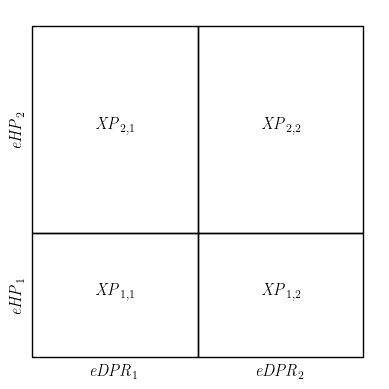

In [94]:
# An example encounter diagram for two NPCs
eDPRs = [4, 4]
eHPs  = [3, 5]

damage = [
    {'targets': [1], 'damage': 5, 'efficiency': 1.0, 'color': 'w'},
    {'targets': [0], 'damage': 3, 'efficiency': 1.0, 'color': 'w'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)


fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
ax = generate_XP_diagram(ax, eHPs, eDPRs, XP_log, fontsize=12)

if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-two-npcs.svg', metadata=METADATA)

enc_XP_total = encounter_XP(eDPRs, eHPs)
adj_XP_total = adjusted_XP_total(XP_log)
print('encounter multiplier: {:.2f}'.format(adj_XP_total/enc_XP_total))
eHP_total = sum(eHPs)
dmg_total = damage_total(XP_log)
dmg_overflow = damage_overflow_total(XP_log)
print('percent damage done: {} %'.format(100*dmg_total/eHP_total))
print('percent damage overflow: {} %'.format(100*(dmg_overflow/eHP_total)))


encounter multiplier: 1.62
percent damage done: 100.0 %
percent damage overflow: 0.0 %


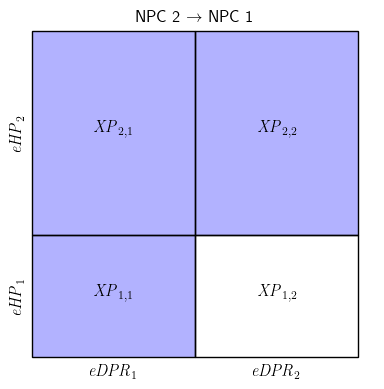

In [95]:
# An example encounter diagram for two NPCs defeated in reverse order using single target damage
eDPRs = [4, 4]
eHPs  = [3, 5]

damage = [
    {'targets': [1], 'damage': 5, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [0], 'damage': 3, 'efficiency': 1.0, 'color': 'b'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)


fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
ax = generate_XP_diagram(ax, eHPs, eDPRs, XP_log, r'NPC 2 $\rightarrow$ NPC 1', fontsize=12)

if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-two-npcs-reverse.svg', metadata=METADATA)

enc_XP_total = encounter_XP(eDPRs, eHPs)
adj_XP_total = adjusted_XP_total(XP_log)
print('encounter multiplier: {:.2f}'.format(adj_XP_total/enc_XP_total))
eHP_total = sum(eHPs)
dmg_total = damage_total(XP_log)
dmg_overflow = damage_overflow_total(XP_log)
print('percent damage done: {} %'.format(100*dmg_total/eHP_total))
print('percent damage overflow: {} %'.format(100*(dmg_overflow/eHP_total)))


encounter multiplier: 1.38
percent damage done: 100.0 %
percent damage overflow: 0.0 %


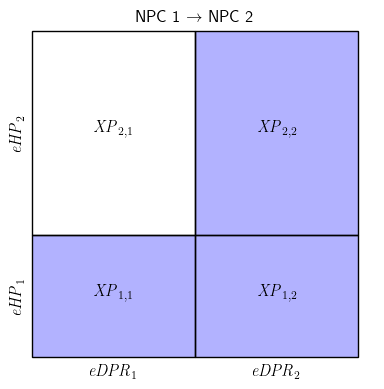

In [96]:
# An example encounter diagram for two NPCs defeated in order using single target damage
eDPRs = [4, 4]
eHPs  = [3, 5]

damage = [
    {'targets': [0], 'damage': 3, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [1], 'damage': 5, 'efficiency': 1.0, 'color': 'b'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
ax = generate_XP_diagram(ax, eHPs, eDPRs, XP_log, r'NPC 1 $\rightarrow$ NPC 2', fontsize=12)

if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-two-npcs-forward.svg', metadata=METADATA)

enc_XP_total = encounter_XP(eDPRs, eHPs)
adj_XP_total = adjusted_XP_total(XP_log)
print('encounter multiplier: {:.2f}'.format(adj_XP_total/enc_XP_total))
eHP_total = sum(eHPs)
dmg_total = damage_total(XP_log)
dmg_overflow = damage_overflow_total(XP_log)
print('percent damage done: {} %'.format(100*dmg_total/eHP_total))
print('percent damage overflow: {} %'.format(100*(dmg_overflow/eHP_total)))


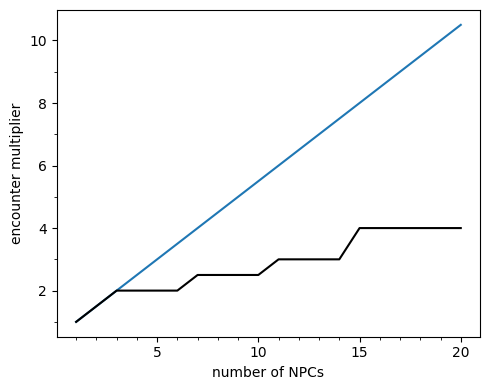

In [43]:
# Single target encounter multiplier as a function of the number of NPCs.

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlabel='number of NPCs', ylabel='encounter multiplier')

nCs = list(range(1, 21))
ax.plot(nCs, [encounter_multiplier_approx_single(n, 1, 1) for n in nCs], label='single target')

# DMG
y = [1.0]*len(nCs)
for i in range(len(nCs)):
    y[i] = encounter_multiplier_DMG(nCs[i])
plt.plot(nCs, y, '-', c='black', label='DMG')

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))

#ax.grid(which='major', axis='both', alpha=0.4)

if SAVEFIGS: fig.savefig('./fig-encounter-approximate-general-single-target.svg', metadata=METADATA)


encounter multiplier: 1.00
percent damage done: 100.0 %
percent damage overflow: 25.0 %


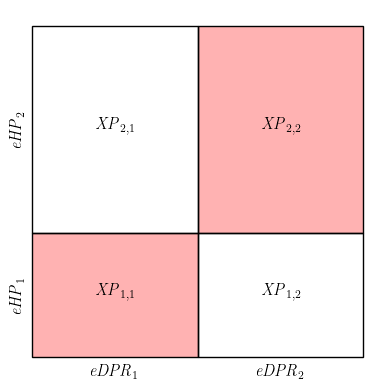

In [100]:
# An example encounter diagram for two NPCs defeated in order using single target damage
eDPRs = [4, 4]
eHPs  = [3, 5]

damage = [
    {'targets': [0,1], 'damage': 5, 'efficiency': 1.0, 'color': 'r'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
ax = generate_XP_diagram(ax, eHPs, eDPRs, XP_log, fontsize=12)

if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-two-npcs-multi-uniform.svg', metadata=METADATA)

enc_XP_total = encounter_XP(eDPRs, eHPs)
adj_XP_total = adjusted_XP_total(XP_log)
print('encounter multiplier: {:.2f}'.format(adj_XP_total/enc_XP_total))
eHP_total = sum(eHPs)
dmg_total = damage_total(XP_log)
dmg_overflow = damage_overflow_total(XP_log)
print('percent damage done: {} %'.format(100*dmg_total/eHP_total))
print('percent damage overflow: {} %'.format(100*(dmg_overflow/eHP_total)))


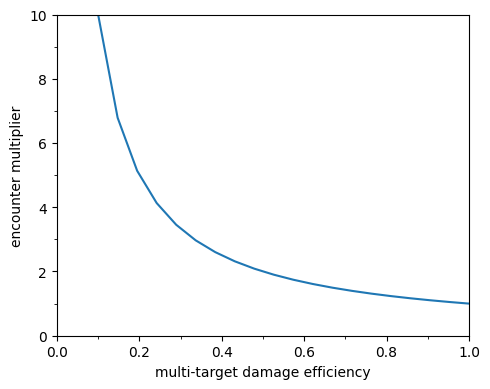

In [40]:
# Multi-target encounter multiplier as a function of multi-target damage efficiency.

eff = np.linspace(0.1, 1.0, 20)
em = [encounter_multiplier_approx_multiple(1, 1, x) for x in eff]


fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlabel='multi-target damage efficiency', ylabel='encounter multiplier', xlim=[0,1], ylim=[0,10])
ax.plot(eff, em)

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))

#ax.grid(which='major', axis='both', alpha=0.4)

if SAVEFIGS: fig.savefig('./fig-encounter-multiplier-general-multi-target.svg', metadata=METADATA)


encounter multiplier: 1.12
percent damage done: 100.0 %
percent damage overflow: 0.0 %


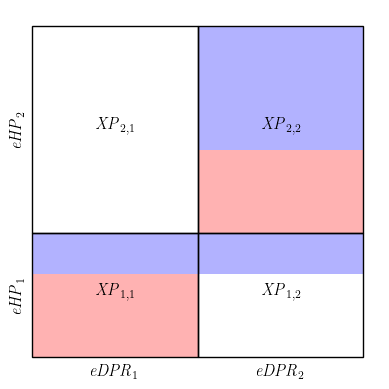

In [99]:
# An example encounter diagram for two NPCs defeated in order using single target damage
eDPRs = [4, 4]
eHPs  = [3, 5]

damage = [
    {'targets': [0,1], 'damage': 2, 'efficiency': 1.0, 'color': 'r'},
    {'targets': [0], 'damage': 1, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [1], 'damage': 3, 'efficiency': 1.0, 'color': 'b'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
ax = generate_XP_diagram(ax, eHPs, eDPRs, XP_log, fontsize=12)

if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-two-npcs-mixed-forward.svg', metadata=METADATA)

enc_XP_total = encounter_XP(eDPRs, eHPs)
adj_XP_total = adjusted_XP_total(XP_log)
print('encounter multiplier: {:.2f}'.format(adj_XP_total/enc_XP_total))
eHP_total = sum(eHPs)
dmg_total = damage_total(XP_log)
dmg_overflow = damage_overflow_total(XP_log)
print('percent damage done: {} %'.format(100*dmg_total/eHP_total))
print('percent damage overflow: {} %'.format(100*(dmg_overflow/eHP_total)))


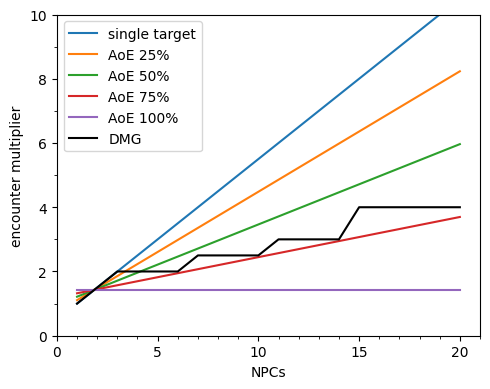

In [76]:
# Plots the encounter multiplier as a function of the number of enemy NPCs.
# All NPCs are assumed to be identical. AoE effects are assumed to damage 
# all NPCs equally.

groups = {
    'single target': {
        'AoE pct': 0.00,
        'AoE eff': 0.70
    },
    'AoE 25%': {
        'AoE pct': 0.25,
        'AoE eff': 0.70
    },
    'AoE 50%': {
        'AoE pct': 0.50,
        'AoE eff': 0.70
    },
    'AoE 75%': {
        'AoE pct': 0.75,
        'AoE eff': 0.70
    },
    'AoE 100%': {
        'AoE pct': 1.00,
        'AoE eff': 0.70
    }
}

n_max = 20
x = range(1, n_max+1)
y = [1.0]*n_max

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0,n_max+1], xlabel='NPCs', ylim=[0,10], ylabel='encounter multiplier')

# groups
for group in groups:
    AoE_pct = groups[group]['AoE pct']
    AoE_eff = groups[group]['AoE eff']
    for i in range(len(x)):
        y[i] = encounter_multiplier_approx_mixed(x[i], AoE_pct, AoE_eff)
    plt.plot(x, y, label=group)

# DMG
for i in range(len(x)):
    y[i] = encounter_multiplier_DMG(x[i])
plt.plot(x, y, '-', c='black', label='DMG')

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.legend(loc='upper left')

#ax.grid(which='major', axis='both', alpha=0.4)

if SAVEFIGS: fig.savefig('./fig-encounter-multiplier-approx-mixed-target.svg', metadata=METADATA)

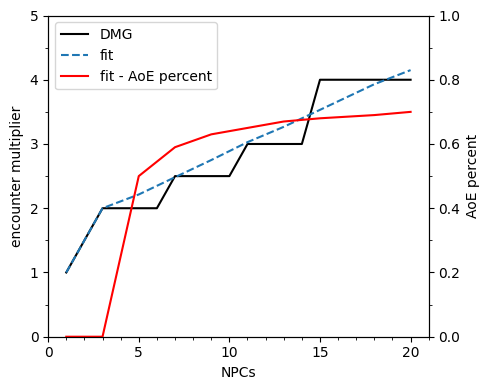

In [90]:
# Plots the encounter multiplier as a function of the number of enemy NPCs.
# All NPCs are assumed to be identical. AoE effects are assumed to damage 
# all NPCs equally.

AoE_eff = 0.70
n_max = 20

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()

# DMG
x = range(1, n_max+1)
y = [encounter_multiplier_DMG(x[i]) for i in range(len(x))]
p1, = ax.plot(x, y, '-', c='black', label='DMG')

# fit
x        = [1, 2, 3,    5,    7,    9,   11,   13,   15,   18,   20] # number of creatures
AoE_pcts = [0, 0, 0, 0.50, 0.59, 0.63, 0.65, 0.67, 0.68, 0.69, 0.70] # AoE damage percentages
y = [encounter_multiplier_approx_mixed(x[i], AoE_pcts[i], AoE_eff) for i in range(len(x))]
p2, = ax.plot(x, y, '--', label='fit')

ax.set_xlim(0, n_max+1)
ax.set_ylim(0, 5.0)

ax.set_xlabel('NPCs')
ax.set_ylabel('encounter multiplier')

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

# fit - AoE percentage
twin1 = ax.twinx()
p3, = twin1.plot(x, AoE_pcts, '-', c='red', label='fit - AoE percent')

twin1.set_ylim(0, 1)
twin1.set_ylabel('AoE percent')

twin1.yaxis.set_major_locator(MultipleLocator(0.2))
twin1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
twin1.yaxis.set_minor_locator(MultipleLocator(0.1))

#ax.grid(which='major', axis='both', alpha=0.4)

ax.legend(loc='upper left', handles=[p1, p2, p3])

#if SAVEFIGS: plt.savefig('./fig-encounter-multiplier-identical-npcs.svg', metadata=METADATA)

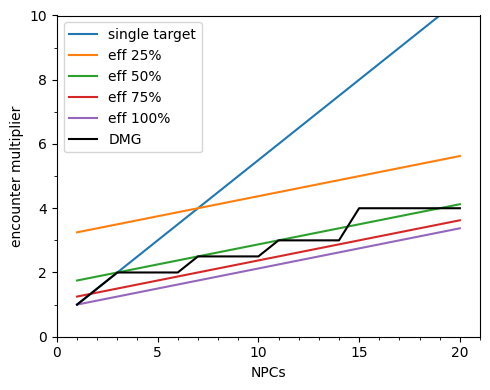

In [91]:
# Plots the encounter multiplier as a function of the number of enemy NPCs.
# All NPCs are assumed to be identical. AoE effects are assumed to damage 
# all NPCs equally.

dMT = 0.75
groups = {
    'single target': {
        'AoE_eff': 1.00,
        'AoE_pct': 0.00
    },
    'eff 25%': {
        'AoE_eff': 0.25,
        'AoE_pct': dMT
    },
    'eff 50%': {
        'AoE_eff': 0.50,
        'AoE_pct': dMT
    },
    'eff 75%': {
        'AoE_eff': 0.75,
        'AoE_pct': dMT
    },
    'eff 100%': {
        'AoE_eff': 1.00,
        'AoE_pct': dMT
    }
}

n_max = 20
x = range(1, n_max+1)
y = [1.0]*n_max

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0,n_max+1], xlabel='NPCs', ylim=[0,10], ylabel='encounter multiplier')

# groups
for group in groups:
    pct = groups[group]['AoE_pct']
    eff = groups[group]['AoE_eff']
    for i in range(len(x)):
        y[i] = encounter_multiplier_approx_mixed(x[i], pct, eff)
    plt.plot(x, y, label=group)

# DMG
for i in range(len(x)):
    y[i] = encounter_multiplier_DMG(x[i])
plt.plot(x, y, '-', c='black', label='DMG')

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.legend(loc='upper left')

#ax.grid(which='major', axis='both', alpha=0.4)

#if SAVEFIGS: fig.savefig('./fig-encounter-multiplier-approx-mixed-target-eff.svg', metadata=METADATA)

encounter multiplier: 1.97
percent damage done: 100.0 %
percent damage overflow: 0.0 %


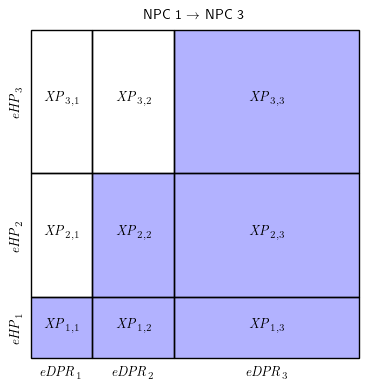

In [433]:
# An example encounter diagram where XP earned from AoE damage is marked in red, and damage earned from single target damage is marked in blue
eDPRs = [3, 4, 9]
eHPs  = [3, 6, 7]

damage = [
    {'targets': [0], 'damage': 3, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [1], 'damage': 6, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [2], 'damage': 7, 'efficiency': 1.0, 'color': 'b'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
ax = generate_XP_diagram(ax, eHPs, eDPRs, XP_log, r'NPC 1 $\rightarrow$ NPC 3')

#if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-single.svg', metadata=METADATA)

enc_XP_total = encounter_XP(eDPRs, eHPs)
adj_XP_total = adjusted_XP_total(XP_log)
print('encounter multiplier: {:.2f}'.format(adj_XP_total/enc_XP_total))
eHP_total = sum(eHPs)
dmg_total = damage_total(XP_log)
dmg_overflow = damage_overflow_total(XP_log)
print('percent damage done: {} %'.format(100*dmg_total/eHP_total))
print('percent damage overflow: {} %'.format(100*(dmg_overflow/eHP_total)))


encounter multiplier: 1.28
percent damage done: 100.0 %
percent damage overflow: 0.0 %


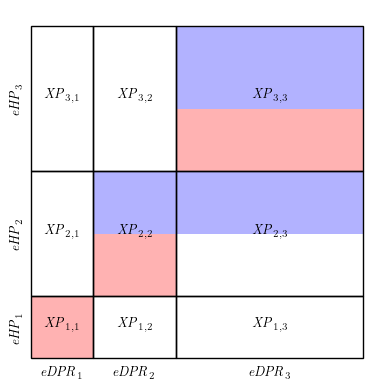

In [434]:
# An example encounter diagram where XP earned from AoE damage is marked in red, and damage earned from single target damage is marked in blue
eDPRs = [3, 4, 9]
eHPs  = [3, 6, 7]
damage = [
    {'targets': [0,1,2], 'damage': 3.0, 'efficiency': 1.0, 'color': 'r'},
    {'targets': [1], 'damage': 3.0, 'efficiency': 1.0, 'color': 'b'},
    {'targets': [2], 'damage': 4.0, 'efficiency': 1.0, 'color': 'b'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
ax = generate_XP_diagram(ax, eHPs, eDPRs, XP_log)

#if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-aoe.svg', metadata=METADATA)

enc_XP_total = encounter_XP(eDPRs, eHPs)
adj_XP_total = adjusted_XP_total(XP_log)
print('encounter multiplier: {:.2f}'.format(adj_XP_total/enc_XP_total))
eHP_total = sum(eHPs)
dmg_total = damage_total(XP_log)
dmg_overflow = damage_overflow_total(XP_log)
print('percent damage done: {} %'.format(100*dmg_total/eHP_total))
print('percent damage overflow: {} %'.format(100*(dmg_overflow/eHP_total)))


encounter multiplier: 1.28
percent damage done: 100.0 %
percent damage overflow: 25.0 %


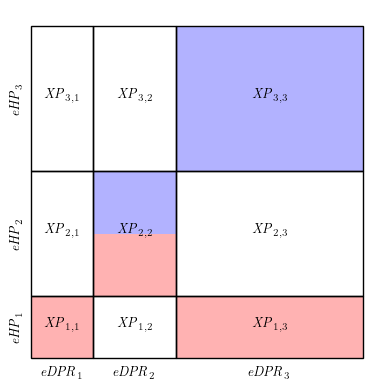

In [477]:
# An example encounter diagram where XP earned from AoE damage is marked in red, and damage earned from single target damage is marked in blue
eDPRs = [3, 4, 9]
eHPs  = [3, 6, 7]
damage = [
    {'targets': [0,1], 'damage': 3.0, 'efficiency': 1.0, 'color': 'r'},
    {'targets': [1,2], 'damage': 7.0, 'efficiency': 1.0, 'color': 'b'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
ax = generate_XP_diagram(ax, eHPs, eDPRs, XP_log)

#if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-aoe.svg', metadata=METADATA)

enc_XP_total = encounter_XP(eDPRs, eHPs)
adj_XP_total = adjusted_XP_total(XP_log)
print('encounter multiplier: {:.2f}'.format(adj_XP_total/enc_XP_total))
eHP_total = sum(eHPs)
dmg_total = damage_total(XP_log)
dmg_overflow = damage_overflow_total(XP_log)
print('percent damage done: {} %'.format(100*dmg_total/eHP_total))
print('percent damage overflow: {} %'.format(100*(dmg_overflow/eHP_total)))


encounter multiplier: 1.19
percent damage done: 100.0 %
percent damage overflow: 12.5 %


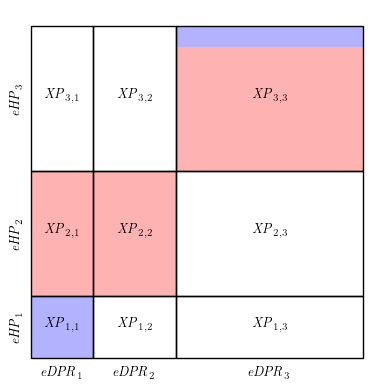

In [479]:
# An example encounter diagram where XP earned from AoE damage is marked in red, and damage earned from single target damage is marked in blue
eDPRs = [3, 4, 9]
eHPs  = [3, 6, 7]
damage = [
    {'targets': [1,2], 'damage': 6.0, 'efficiency': 1.0, 'color': 'r'},
    {'targets': [0,2], 'damage': 3.0, 'efficiency': 1.0, 'color': 'b'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
ax = generate_XP_diagram(ax, eHPs, eDPRs, XP_log)

#if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-aoe.svg', metadata=METADATA)

enc_XP_total = encounter_XP(eDPRs, eHPs)
adj_XP_total = adjusted_XP_total(XP_log)
print('encounter multiplier: {:.2f}'.format(adj_XP_total/enc_XP_total))
eHP_total = sum(eHPs)
dmg_total = damage_total(XP_log)
dmg_overflow = damage_overflow_total(XP_log)
print('percent damage done: {} %'.format(100*dmg_total/eHP_total))
print('percent damage overflow: {} %'.format(100*(dmg_overflow/eHP_total)))


encounter multiplier: 1.19
percent damage done: 100.0 %
percent damage overflow: 12.5 %


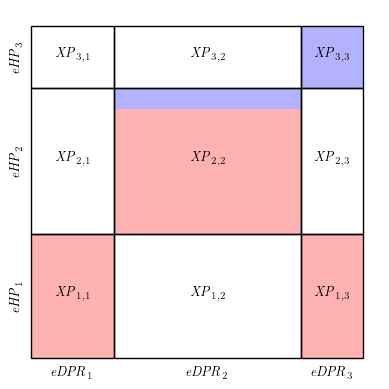

In [480]:
# An example encounter diagram where XP earned from AoE damage is marked in red, and damage earned from single target damage is marked in blue
eDPRs = [4, 9, 3]
eHPs  = [6, 7, 3]
damage = [
    {'targets': [0,1], 'damage': 6.0, 'efficiency': 1.0, 'color': 'r'},
    {'targets': [1,2], 'damage': 3.0, 'efficiency': 1.0, 'color': 'b'}
]

XP_log = create_XP_log(eHPs, eDPRs, damage)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
ax = generate_XP_diagram(ax, eHPs, eDPRs, XP_log)

#if SAVEFIGS: fig.savefig('./fig-xp-encounter-diagram-aoe.svg', metadata=METADATA)

enc_XP_total = encounter_XP(eDPRs, eHPs)
adj_XP_total = adjusted_XP_total(XP_log)
print('encounter multiplier: {:.2f}'.format(adj_XP_total/enc_XP_total))
eHP_total = sum(eHPs)
dmg_total = damage_total(XP_log)
dmg_overflow = damage_overflow_total(XP_log)
print('percent damage done: {} %'.format(100*dmg_total/eHP_total))
print('percent damage overflow: {} %'.format(100*(dmg_overflow/eHP_total)))


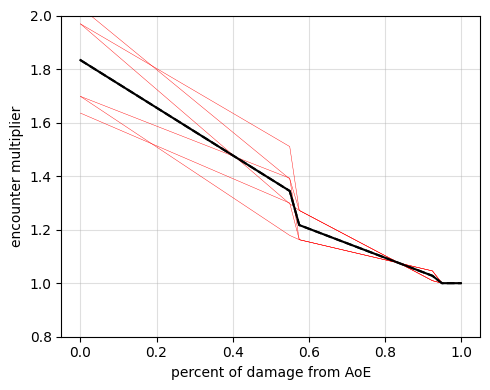

In [555]:
# Calculated encounter multiplier as a function of how much AoE damage is dealt
# by the PCs.
from sympy.utilities.iterables import multiset_permutations

eHPs = np.array([7, 6, 3])
eDPRs  = np.array([9, 4, 3])
nC = len(eHPs)

AoE_pcts = np.linspace(0, 1, 41)
AoE_eff = 1.00

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlabel='percent of damage from AoE', ylabel='encounter multiplier', ylim=[0.8,2.0])

EMs = np.zeros(len(AoE_pcts))
for z in range(len(AoE_pcts)):
    EMs[z] = encounter_multiplier_ave(eHPs, eDPRs, AoE_pcts[z], AoE_eff)
plt.plot(AoE_pcts, EMs, '--', color='k', label='average')


EMs_ave = np.zeros(len(AoE_pcts))
ittr = np.array(range(nC))
for it in multiset_permutations(ittr):
    for z in range(len(AoE_pcts)):
        EMs[z] = encounter_multiplier_ordered(eHPs[it], eDPRs[it], AoE_pcts[z], AoE_eff)
        EMs_ave[z] += EMs[z]
    plt.plot(AoE_pcts, EMs, '-', color='r', label='order {:}'.format(it), linewidth=0.3)

EMs_ave = np.divide(EMs_ave, len(list(multiset_permutations(ittr))))
plt.plot(AoE_pcts, EMs_ave, '-', color='k', label='average')

ax.grid(which='major', axis='both', alpha=0.4)
#ax.label_outer()

#if SAVEFIGS: plt.savefig('./fig-xp-encounter-diagram.svg', metadata=METADATA)

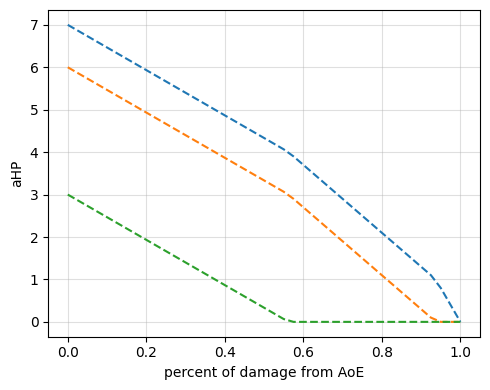

In [524]:
# Calculated encounter multiplier as a function of how much AoE damage is dealt
# by the PCs.
from sympy.utilities.iterables import multiset_permutations

eHPs = np.array([7, 6, 3])
eDPRs  = np.array([9, 4, 3])
nC = len(eHPs)

nA = 41
AoE_pcts = np.linspace(0, 1, nA)
AoE_eff = 1.00

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlabel='percent of damage from AoE', ylabel='aHP')

aHPs = np.zeros((nC,nA))
for z in range(len(AoE_pcts)):
    aHPs[:,z] = encounter_sHPs(eHPs, AoE_pcts[z])

for i in range(nC):
    ax.plot(AoE_pcts, aHPs[i,:], '--')

ax.grid(which='major', axis='both', alpha=0.4)
#ax.label_outer()

#if SAVEFIGS: plt.savefig('./fig-xp-encounter-diagram.svg', metadata=METADATA)

Encounter Multiplier: 1.28.


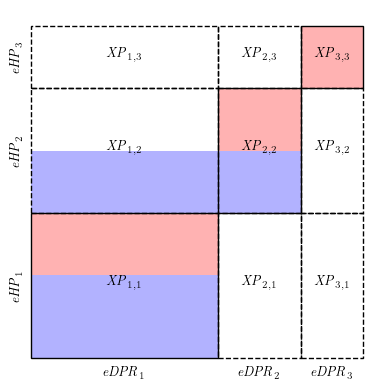

In [275]:
# An example encounter diagram where XP earned from AoE damage is marked in red, and damage earned from single target damage is marked in blue
eDPRs = [9, 4, 3]
eHPs  = [7, 6, 3]
x_mins = [sum(eDPRs[0:i]) for i in range(len(eDPRs))]
y_mins = [sum(eHPs[0:i]) for i in range(len(eHPs))]
x_max = sum(eDPRs)
y_max = sum(eHPs)

nC = len(eDPRs)

AoE_pct = 9/16
AoE_eff = 1.0

XP = encounter_XP(eDPRs, eHPs)

plt.rcParams['text.usetex'] = True
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()

rectangle = plt.Rectangle((0,0), x_max, y_max, fc='white', ec='none', alpha=1.0)
ax.add_patch(rectangle)

# determine the adjusted effective HP after accounting for AoE damage
aHPs = encounter_aHPs(eHPs, AoE_pct)
inds = np.argsort([i == 0 for i in aHPs])

# create actual XP rectangles
for i in range(nC):
    for j in range(nC):
        ii = inds[i]
        jj = inds[j]
        x = x_mins[ii]
        y = y_mins[jj]
        eDPR = eDPRs[ii]
        eHP = eHPs[jj]
        aHP = aHPs[jj]
        if i > j:
            fc = 'white'
        elif i < j:
            rectangle = plt.Rectangle((x, y), eDPR, aHP, fc='blue', ec='none', alpha=0.3)
            ax.add_patch(rectangle)
        else:
            rectangle = plt.Rectangle((x, y+aHP), eDPR, (eHP - aHP), fc='red', ec='none', alpha=0.3)
            ax.add_patch(rectangle)
            rectangle = plt.Rectangle((x, y), eDPR, aHP, fc='blue', ec='none', alpha=0.3)
            ax.add_patch(rectangle)

# create XP rectangles
for i in range(3):
    for j in range(3):
        if i == j:
            fc = 'none'
            ls = '-'
        else:
            fc = 'none'
            ls = '--'

        rectangle = plt.Rectangle((x_mins[i],y_mins[j]), eDPRs[i], eHPs[j], fc='none', ec='black', linestyle=ls)
        ax.add_patch(rectangle)

        ax.text(x_mins[i] + 0.5*eDPRs[i], y_mins[j] + 0.5*eHPs[j], 
            r'$\mathit{{XP}}_{{{:},{:}}}$'.format(i+1,j+1), fontsize=10, ha='center')

# create axes labels
for i in range(3):
    ax.text(x_mins[i] + 0.5*eDPRs[i], -0.7, r'$\mathit{{eDPR}}_{{{:}}}$'.format(i+1), fontsize=10, ha='center', va='center')
    ax.text(-0.7, (y_mins[i] + 0.5*eHPs[i]), r'$\mathit{{eHP}}_{{{:}}}$'.format(i+1), fontsize=10, ha='center', va='center', rotation='vertical')

plt.axis('off')
plt.axis('scaled')

EM = encounter_multiplier_ordered(eHPs, eDPRs, AoE_pct, AoE_eff)
print('Encounter Multiplier: {:.2f}.'.format(EM))

#if SAVEFIGS: plt.savefig('./fig-xp-encounter-diagram-aoe.svg', metadata=METADATA)

plt.rcParams['text.usetex'] = False


In [466]:
import re

def deq_parse_equation(diceEqn):
    s = re.split(r'(\+|\-)', diceEqn)
    return s

def deq_single_average_value(diceEqn):
    m = re.match(r'\s*(\d*)d(\d+)\s*', diceEqn)
    n = int(m.group(1)) if m.group(1) else 1
    a = 0.5*(int(m.group(2)) + 1)
    return n*a

def deq_multi_average_value(diceEqn):
    s = deq_parse_equation(diceEqn)
    deq = s.pop(0)
    atot = deq_single_average_value(deq)
    it = iter(s)
    for x in it:
        if x == '+':
            atot += deq_single_average_value(next(it))
        else:
            atot -= deq_single_average_value(next(it))
    return atot

spLvl = [0,1,2,3,4,5,6,7,8,9]
spDmgS = ['1d10','2d10','3d10','5d10','6d10','8d10','10d10','11d10','12d10','15d10']
spDmgM = ['1d6','2d6','4d6','6d6','7d6','8d6','11d6','12d6','13d6','14d6']

spDmgRat = [0]*len(spLvl)
for i in range(len(spLvl)):
    spDmgRat[i] = deq_multi_average_value(spDmgM[i])/deq_multi_average_value(spDmgS[i])

print(np.mean(spDmgRat))

0.6941184573002754
